In [1]:
# Need to scale problem better
# Need to include the cost function

In [2]:
%reset # clears variables in workspace

# import libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition
import sympy as sym
import numpy as np
from IPython.display import display
from sympy import pprint

# import EOM
import dill
dill.load_session('simplified_monopod.db')

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g] + [LL] +\
           [masses[base] for base in bases] +\
           [masses[link,leg] for leg in legs for link in links] +\
           [lengths[base] for base in bases] +\
           [lengths[link,leg] for leg in legs for link in links] +\
           [inertias[base] for base in bases] +\
           [inertias[link,leg] for leg in legs for link in links] +\
           [x_body]+[y_body]+[th_body] + [th[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [dx_body]+[dy_body]+[dth_body] + [dth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [ddx_body]+[ddy_body]+[ddth_body] + [ddth[link,leg] for leg in legs for link in links if 'foot' not in link] +\
           [tau['left',leg] for leg in legs] + [tau['right',leg] for leg in legs] +\
           [lamda['x',leg] for leg in legs] + [lamda['y',leg] for leg in legs] +\
           [GRF['x',leg] for leg in legs] + [GRF['y',leg] for leg in legs]

lamb_EOMs = {}

DOFs = ['x_body'] + ['y_body'] +['theta_body']

for leg in legs:
    for link in links:
        if 'foot' not in link:
            DOFs = DOFs + ['theta_{0}'.format(link+leg)]

for dof_i,dof in enumerate(DOFs):
    lamb_EOMs.update({dof: sym.lambdify(sym_list,EOMs[dof_i],modules = [func_map])})


Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #, please run `%reset?` for details
Don't know how to reset  clears, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Flushing input history
Don't know how to reset  workspace, please run `%reset?` for details


In [3]:
# PARAMETERS:
masses_ = {'body': 2.06,
           'ullA': 0.31,
           'lllA': 0.53,
           'urlA': 0.31,
           'lrlA': 0.53,
           'footA': 0.07,
           'boom': 1.806}

lengths_ = {'body': 24/100,
            'ullA': 17.5/100,
            'lllA': 30.0/100,
            'urlA': 17.5/100,
            'lrlA': 30.0/100,
            'footA': 4.5/100,
            'boom': 0}

''' ****** '''
inertias_ = {'body': (masses_['body']*lengths_['body']**2)/12, # body rotate about its center 
            'ullA': (masses_['ullA']*lengths_['ullA']**2)/3, # rotates as pendulumn 
            'urlA': (masses_['urlA']*lengths_['urlA']**2)/3,
            'lllA': (masses_['lllA']*lengths_['lllA']**2)/3,
            'lrlA': (masses_['lrlA']*lengths_['lrlA']**2)/3,
            'footA': (masses_['footA']*lengths_['footA']**2)/3,
            'boom': 0}

In [4]:
WDOFs = ['X','Y'] 
signs = ['-ve','+ve'] 
legs = ['A']
links = ['ull','lll','url','lrl','foot']
bases = ['body','boom']
ground_constraints = ['contact','friction','slip_+ve','slip_-ve'] # Group all constraints occuring at the ground
sides = ['left','right']
coordinates = {'X':0 , 'Y':1}
motor_w_angle = {'left': 'ull' ,'right': 'url'}
all_links = []
for leg in legs:
    for link in links:
        all_links.append(link+leg)
        
[all_links.append(base) for base in bases]

def get_var_list_zeros(m,n):
    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs] +\
               [0 for leg in legs] + [0 for leg in legs]
    return var_list

def get_var_list_values(m,n):
    
    BW = 1
    tau_value = {}
    connection_force_value = {}
    GRF_X_value = {}
    GRF_Y_value = {}
    
    for leg in legs:
        
#         [tau_value.update({(side,leg): BW*(m.tau_torque[n,'+ve',side,leg]-m.tau_torque[n,'-ve',side,leg])}) for side in sides]
#         [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,'+ve',wdof,leg]-m.connect_force[n,'-ve',wdof,leg])}) for wdof in WDOFs]
#         GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
#         GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

        [tau_value.update({(side,leg): BW*(m.tau_torque[n,'+ve',side,leg]-m.tau_torque[n,'-ve',side,leg])}) for side in sides]
        [connection_force_value.update({(wdof,leg):BW*(m.connect_force[n,'+ve',wdof,leg]-m.connect_force[n,'-ve',wdof,leg])}) for wdof in WDOFs]
        GRF_X_value.update({(leg):BW*(m.GRF_x[n,'+ve',leg]-m.GRF_x[n,'-ve',leg])})
        GRF_Y_value.update({(leg):BW*(m.GRF_y[n,leg])})

    var_list = [m.g] + [m.LL] +\
               [m.masses[base] for base in bases] +\
               [m.masses[link+leg] for leg in legs for link in links] +\
               [m.lengths[base] for base in bases] +\
               [m.lengths[link+leg] for leg in legs for link in links] +\
               [m.inertias[base] for base in bases] +\
               [m.inertias[link+leg] for leg in legs for link in links] +\
               [m.q[n,dof] for dof in DOFs] +\
               [m.dq[n,dof] for dof in DOFs] +\
               [m.ddq[n,dof] for dof in DOFs] +\
               [tau_value['left',leg] for leg in legs] + [tau_value['right',leg] for leg in legs] +\
               [connection_force_value['X',leg] for leg in legs] + [connection_force_value['Y',leg] for leg in legs] +\
               [GRF_X_value[leg] for leg in legs] + [GRF_Y_value[leg] for leg in legs]
    return var_list


<a id='time_step'></a>

In [5]:
N = 50
TT = 1.0

m = ConcreteModel('Monopod')

#SETS-------------------------
m.N = RangeSet(N)
m.ground_constraints = Set(initialize = ground_constraints)
m.legs = Set(initialize = legs)
m.links = Set(initialize = links)
m.bases = Set(initialize = bases)
m.all_links = Set(initialize = all_links)
m.DOFs = Set(initialize = DOFs)
m.WDOFs = Set(initialize = WDOFs)
m.signs = Set(initialize = signs)
m.sides = Set(initialize = sides)


#Params--------------------------
m.g = Param(initialize = 9.81)
m.LL = Param(initialize = 7.5/100)

# m.masses = Param(m.links, initialize = masses)
m.masses = Param(m.all_links, initialize = masses_)
m.lengths = Param(m.all_links, initialize = lengths_)
m.inertias = Param(m.all_links, initialize = inertias_)


#VARIABLES----------------------
#gen coordinates
m.q = Var(m.N,m.DOFs)
m.dq = Var(m.N,m.DOFs)
m.ddq = Var(m.N,m.DOFs)

In [6]:
# variable timestep
hm = TT/N # master timestep
m.h = Var(m.N, bounds = (0.8,1.2))

In [7]:
''' CONSTRAINTS  - Integration'''
 
def BwEuler_p(m,n,dof):
    if n > 1:
        return m.q[n,dof] == m.q[n-1,dof] + hm*m.h[n]*m.dq[n,dof]
    else:
        return Constraint.Skip
m.integrate_p = Constraint(m.N, m.DOFs, rule = BwEuler_p)

def BwEuler_v(m,n,dof):
    if n > 1:
        return m.dq[n,dof] == m.dq[n-1,dof] + hm*m.h[n]*m.ddq[n,dof]
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.DOFs, rule = BwEuler_v)

In [8]:
# Variable of boom position
m.boom_position = Var(m.N, m.WDOFs)

# Get the boom position in WDOF
lamb_boom_position = {} 

[lamb_boom_position.update({WDOF: sym.lambdify(sym_list,r_bases['boom'][coordinates[WDOF]].simplify(),modules = [func_map])}) for WDOF in WDOFs]
    
def def_boom_position(m,n,wdof):
    var_list = get_var_list_zeros(m,n)
    return m.boom_position[n,wdof] == lamb_boom_position[wdof](*var_list)
m.def_boom_position = Constraint(m.N, m.WDOFs, rule = def_boom_position)


In [9]:
''' CONSTRAINTS  - CONNECTION POINT'''

m.connect_position = Var(m.N, m.WDOFs, m.sides, m.legs) # connection point
m.connect_force = Var(m.N, m.signs, m.WDOFs, m.legs, bounds = (0.0,None)) # connection force

# Lamdify
lamb_connect_position = {} # (WDOFs,sides,leg)
[lamb_connect_position.update({(wdof,side,leg): sym.lambdify(sym_list,connect_position[side,leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for side in sides for wdof in WDOFs]

# Equate the connection equations from the previous script to the model m
def def_connect_position_equation(m,n,wdof,side,leg):
    var_list = get_var_list_zeros(m,n)    
    return m.connect_position[n,wdof,side,leg] == lamb_connect_position[wdof,side,leg](*var_list)
m.connect_position_equation = Constraint(m.N, m.WDOFs, m.sides, m.legs, rule = def_connect_position_equation)

# Ensure that there is no distance between the X (and Y) of link connection points
def def_connect_position(m,n,wdof,leg):
    return  m.connect_position[n,wdof,'right',leg] - m.connect_position[n,wdof,'left',leg] == 0.0
m.connect_position_constraint = Constraint(m.N, m.WDOFs, m.legs, rule= def_connect_position)

In [10]:
#Variable of foot position
m.foot_position = Var(m.N, m.WDOFs, m.legs)

#Get the foot position in WDOF
lamb_foot_position = {}
[lamb_foot_position.update({(wdof,leg): sym.lambdify(sym_list,foot_position[leg][coordinates[wdof]],modules = [func_map])}) for leg in legs for wdof in WDOFs]

def def_foot_position(m,n,wdof,leg):
    var_list = get_var_list_zeros(m,n)
    return m.foot_position[n,wdof,leg] == lamb_foot_position[wdof,leg](*var_list)
m.def_foot_position = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_position)

m.mu = Param(initialize = 1,within=Any)

# Variables
m.foot_velocity = Var(m.N, m.WDOFs, m.signs, m.legs, bounds = (0.0,None)) # the sign will account for -ve velocities
m.friction_cone = Var(m.N, m.legs, bounds = (0.0,None)) 
m.GRF_y = Var(m.N, m.legs, bounds = (0.0,None)) # ground reaction forces
m.GRF_x = Var(m.N, m.signs, m.legs, bounds = (0.0,None)) # ground reaction forces
m.ground_penalty = Var(m.N, m.ground_constraints, m.legs, bounds = (0.0,None)) # penalty

lamb_foot_velocity_x = {}

# Get the foot position in WDOF
[lamb_foot_velocity_x.update({(leg): sym.lambdify(sym_list,(foot_position[leg].jacobian(q)*dq)[0].simplify(),modules = [func_map])}) for leg in legs]

# CONSTRAINTS
def def_foot_velocity(m,n,wdof,leg):
    if wdof == 'X':
        var_list = get_var_list_zeros(m,n)
        return m.foot_velocity[n,'X','+ve',leg]-m.foot_velocity[n,'X','-ve',leg] == lamb_foot_velocity_x[leg](*var_list)
    else: return Constraint.Skip
m.foot_velocity_constraint = Constraint(m.N, m.WDOFs, m.legs, rule = def_foot_velocity)

def def_friction_cone(m,n,leg):
    return m.friction_cone[n,leg] == m.mu*m.GRF_y[n,leg] - (m.GRF_x[n,'+ve',leg] + m.GRF_x[n,'-ve',leg])
m.friction_cone_constraint = Constraint(m.N, m.legs, rule = def_friction_cone)

# constraints: complementarity

# contact
def def_ground_contact(m,n,leg):
    if n < N:
        return m.ground_penalty[n,'contact',leg] == m.foot_position[n+1,'Y',leg]*m.GRF_y[n,leg] 
    else:
        return Constraint.Skip
m.ground_contact_constraint = Constraint(m.N, m.legs, rule = def_ground_contact)

# friction
def def_ground_friction(m,n,leg):
    return m.ground_penalty[n,'friction',leg] == (m.foot_velocity[n,'X','+ve',leg]+m.foot_velocity[n,'X','-ve',leg])*m.friction_cone[n,leg]
m.ground_friction_constraint = Constraint(m.N, m.legs, rule = def_ground_friction)

# slipping
def def_ground_slip_positive(m,n,leg):
    return m.ground_penalty[n,'slip_+ve',leg] == m.foot_velocity[n,'X','+ve',leg]*m.GRF_x[n,'+ve',leg]
m.ground_slip_positive_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_positive)

def def_ground_slip_negative(m,n,leg):
    return m.ground_penalty[n,'slip_-ve',leg] == m.foot_velocity[n,'X','-ve',leg]*m.GRF_x[n,'-ve',leg]
m.ground_slip_negative_constraint = Constraint(m.N, m.legs, rule = def_ground_slip_negative)

# bound contact forces at last node
for leg in legs:
    m.GRF_y[N,leg].fix(0.0)
    for sgn in signs:
        m.GRF_x[N,sgn,leg].fix(0.0)


Text(0, 0.5, 'Torque (Nm)')

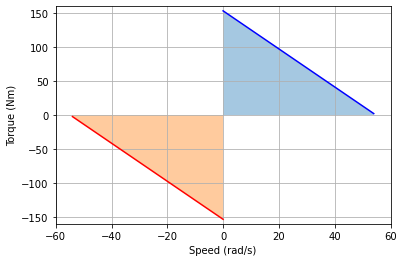

In [11]:
'''Plot Torque Speed Curve'''
import matplotlib.pyplot as plt
x_p = np.linspace(0, 54, num=54)
x_n = np.linspace(-54, 0, num=54)
y_p = -2.8*x_p + 153.4
y_n = -2.8*x_n - 153.4

plt.grid()
plt.plot(x_p, y_p,'b')
plt.fill_between(x_p, y_p, alpha=0.4)

plt.plot(x_n, y_n,'r')
plt.fill_between(x_n, y_n, alpha=0.4)

plt.axis((-60,60,-160,160))
plt.xlabel('Speed (rad/s)')
plt.ylabel('Torque (Nm)')

In [12]:
# m.tau_torque = Var(m.N, m.sides, m.legs, bounds = (0.0,38.0))

In [13]:
'''Constant Power - Speed Torque Curve'''

m.tau_torque = Var(m.N, m.signs, m.sides, m.legs, bounds = (0.0,38.0))
m.tau_velocity = Var(m.N, m.signs, m.sides, m.legs, bounds = (0.0,46.0))

lamb_tau_velocity = {}
[lamb_tau_velocity.update({(side,leg): sym.lambdify(sym_list,w_links[motor_w_angle[side],leg],modules = [func_map])}) for leg in legs for side in sides]

def def_angular_velocity(m,n,side,leg):
    var_list = get_var_list_zeros(m,n)
    return m.tau_velocity[n,'+ve',side,leg]-m.tau_velocity[n,'-ve',side,leg] == lamb_tau_velocity[side,leg](*var_list)
m.left_angular_velocity_constraint = Constraint(m.N, m.sides, m.legs, rule = def_angular_velocity)

# assume straight line
def def_constant_power(m,n,sign,side,leg):
    if sign == '+ve':
        return m.tau_torque[n,sign,side,leg] <= m.tau_velocity[n,sign,side,leg]*(-2.8) + 153.4
    else:
        return m.tau_torque[n,sign,side,leg] >= m.tau_velocity[n,sign,side,leg]*(-2.8) - 153.4
m.constant_power = Constraint(m.N, m.signs, m.sides, m.legs, rule = def_constant_power)

In [14]:
# Set the angles for the knees - only use this when actuated 
# This ensures links does not cross
m.knee_angle = Var(m.N, m.sides, bounds = (0.0,170*(np.pi)/180))

def def_knee_angle(m,n,side,leg):
    if side == 'left':
        return m.knee_angle[n,side] == 2*np.pi - m.q[n,'theta_lll'+leg]
    else:
        return m.knee_angle[n,side] == m.q[n,'theta_lrl'+leg]   
m.knee_angle_constraint = Constraint(m.N, m.sides, m.legs, rule = def_knee_angle)

<a id='initial_conditions'></a>

In [15]:
''' Use this code for tests '''

tests = ["High_Drop_Test","Low_Drop_Test","Hop_Test","Drop_Hop_Test"]

test = tests[3]

# BOUND VALUES

for n in range(1,N+1):
    
    
    if test == "High_Drop_Test" or test == "Low_Drop_Test":
        [m.tau_torque[n,sign,side,leg].fix(0.0) for side in sides for sign in signs for leg in legs]
    
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = 0.0
        y_high_lim = 2.0
    
        m.q[n,'theta_body'].setub(np.pi*(1/3))
        m.q[n,'theta_body'].setlb(np.pi*(-1/3))

        sign_symbols = ['+','-']
        boundaries = ['setub','setlb']

        for leg in legs:
            m.foot_position[n, 'Y', leg].setlb(0.0)
            for dof in DOFs:
                m.dq[1,dof].fix(0.0)
            for index in range(len(boundaries)):
                eval('m.q[n,\'theta_ull\'+leg].{0}(np.pi*(0.5{1}1/3))'.format(boundaries[index],sign_symbols[index]))
                eval('m.q[n,\'theta_lll\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
                eval('m.q[n,\'theta_url\'+leg].{0}(np.pi*(0.5{1}1/3))'.format(boundaries[index],sign_symbols[index]))    
                eval('m.q[n,\'theta_lrl\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))
    
    else:
        [m.tau_torque[1,sign,side,leg].fix(0.0) for side in sides for sign in signs for leg in legs]
        
        #if n<=round(N/4): # before it hits the ground turn off all torques
        #    [m.tau_torque[n,sign,side,leg].fix(0.0) for side in sides for sign in signs for leg in legs]
        
        # Set graph limits 
        x_low_lim = -1.0
        x_high_lim = 1.0
        y_low_lim = 0.0
        y_high_lim = 1.5
        
        m.q[n,'theta_body'].setub(np.pi*(1/3))
        m.q[n,'theta_body'].setlb(np.pi*(-1/3))

        sign_symbols = ['+','-']
        boundaries = ['setub','setlb']

        for leg in legs:
            m.foot_position[n, 'Y', leg].setlb(0.0)
            for dof in DOFs:
                m.dq[1,dof].fix(0.0)
            for index in range(len(boundaries)):
                eval('m.q[n,\'theta_ull\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))
                eval('m.q[n,\'theta_lll\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))  
                eval('m.q[n,\'theta_url\'+leg].{0}(np.pi*(0.5{1}1/2))'.format(boundaries[index],sign_symbols[index]))    
                eval('m.q[n,\'theta_lrl\'+leg].{0}(np.pi*(1{1}1/2))'.format(boundaries[index],sign_symbols[index]))

if test == "High_Drop_Test":
    #  ----------------------------- HIGH DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(1.0)

    for leg in legs:
        m.q[1,'theta_ull'+leg].fix(np.pi*(0.5-1/10))
        m.q[1,'theta_url'+leg].fix(np.pi*(0.5+1/10))
        
elif test == "Low_Drop_Test":
    #  ----------------------------- LOW DROP TEST ---------------------------

    # initial condition
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.3)

    for leg in legs:
        m.q[1,'theta_ull'+leg].fix(np.pi*(0.5-1/10))
        m.q[1,'theta_url'+leg].fix(np.pi*(0.5+1/10))
        
elif test == "Hop_Test":
    #  ----------------------------- HOP TEST ---------------------------

    # initial condition
    m.q[1,'y_body'].fix(0.35)
    m.q[1,'x_body'].fix(0.0)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.foot_position[1, 'Y', 'A'].fix(0.0)
        
    m.q[N,'y_body'].setlb(0.8)

elif test == "Drop_Hop_Test":
    #  ----------------------------- DROP HOP TEST ---------------------------
    
    # initial condition
    x_ref = 0.0
    m.q[1,'x_body'].fix(x_ref)
    m.q[1,'theta_body'].fix(np.pi*(0.0))
    m.q[1,'theta_ullA'].fix(np.pi*(0.5-0.1))
    m.q[1,'theta_urlA'].fix(np.pi*(0.5+0.1))
    m.foot_position[1, 'Y', 'A'].fix(0.3)
        
    m.foot_position[round(N/5), 'Y', 'A'].setub(0.05)
    m.foot_position[N, 'Y', 'A'].setlb(0.3)
    m.foot_position[N, 'X', 'A'].setub(x_ref+0.2)
    m.foot_position[N, 'X', 'A'].setlb(x_ref-0.2)

    # m.q[round(N/4),'y_body'].setub(0.4)
    m.q[N,'x_body'].setub(x_ref+0.05)
    m.q[N,'x_body'].setlb(x_ref-0.05)
    
else: pass

In [16]:
# COST FUNCTION -------------------------------------------------------------------------------------------------------------
def CostFun(m):
    # T = sum(m.h[n] for n in range(1,N+1)) # minimum time
    tau_sum = 0
    pen_sum = 0
    T = sum(m.h[n] for n in range(1,N+1))
    for n in range(1,N+1):
        for leg in legs:
            for side in sides:
                tau_sum = tau_sum + (m.tau_torque[n,'+ve',side,leg]-m.tau_torque[n,'-ve',side,leg])**2 
            for gc in ground_constraints:
                pen_sum += m.ground_penalty[n,gc,leg] 
    return T +(10^3)*pen_sum # + tau_sum
m.Cost = Objective(rule = CostFun)

In [17]:
''' Turning EOM back to pyomo (from sympy) '''
#create the constraints
def EOM_x_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['x_body'](*var_list) == 0
m.EOM_x_body_constraint = Constraint(m.N, rule = EOM_x_body)

def EOM_y_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['y_body'](*var_list) == 0
m.EOM_y_body_constraint = Constraint(m.N, rule = EOM_y_body)

def EOM_th_body(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_body'](*var_list) == 0
m.EOM_th_body_constraint = Constraint(m.N, rule = EOM_th_body)

def EOM_th_ullA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_ullA'](*var_list) == 0
m.EOM_th_ullA_constraint = Constraint(m.N, rule = EOM_th_ullA)

def EOM_th_lllA(m,n):
    var_list = get_var_list_values(m,n)
    return lamb_EOMs['theta_lllA'](*var_list) == 0
m.EOM_th_lllA_constraint = Constraint(m.N, rule = EOM_th_lllA)

def EOM_th_urlA(m,n):
    var_list = get_var_list_values(m,n)   
    return lamb_EOMs['theta_urlA'](*var_list) == 0
m.EOM_th_urlA_constraint = Constraint(m.N, rule = EOM_th_urlA)

def EOM_th_lrlA(m,n):
    var_list = get_var_list_values(m,n)    
    return lamb_EOMs['theta_lrlA'](*var_list) == 0
m.EOM_th_lrlA_constraint = Constraint(m.N, rule = EOM_th_lrlA)

In [18]:
# solving
opt = SolverFactory('ipopt',executable = '/home/zubair/build/bin/ipopt')
opt.options["linear_solver"] = 'ma86'

# solver options
opt.options["expect_infeasible_problem"] = 'yes'
#pt.options["linear_system_scaling"] = 'none'
#opt.options["mu_strategy"] = "adaptive"
opt.options["print_level"] = 5     # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 30000    # maximum number of iterations
opt.options["max_cpu_time"] = 600  # maximum cpu time in seconds
opt.options["Tol"] = 1e-6          # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.

results = opt.solve(m, tee = True)

Ipopt 3.14.5: linear_solver=ma86
expect_infeasible_problem=yes
print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma86.

Number of nonzeros in equality constraint Jacobian...:    12787
Number of nonzeros in inequality constraint Jacobian.:      396
Number of nonzeros in Lagrangian Hessian.............:     5602

Total number of variables............................:     2681
                     variables with only lower bounds:      745
                variables with lower and upper bounds:      796
                     variables with only upp

  96r 1.4944615e+03 2.39e-01 4.23e+01  -4.1 4.64e+02    -  2.31e-02 1.27e-02f  1
  97r 1.5453460e+03 2.38e-01 7.87e+01  -4.1 3.37e+02    -  2.74e-02 5.92e-03f  1
  98r 1.7603949e+03 2.32e-01 7.37e+01  -4.1 3.36e+02    -  2.27e-02 2.46e-02f  1
  99r 1.9370663e+03 2.27e-01 6.84e+01  -4.1 3.44e+02    -  1.81e-02 2.07e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 2.0753489e+03 2.24e-01 6.28e+01  -4.1 3.59e+02    -  1.30e-02 1.61e-02f  1
 101r 2.1320616e+03 2.23e-01 6.09e+01  -4.1 3.91e+02    -  5.48e-03 6.42e-03f  1
 102r 2.2624644e+03 2.21e-01 5.59e+01  -4.1 5.44e+01  -2.0 2.73e-02 3.02e-02f  1
 103r 2.3977199e+03 2.27e-01 4.40e+01  -4.1 1.21e+02  -2.5 7.04e-03 1.97e-02f  1
 104r 2.4314346e+03 2.27e-01 8.22e+01  -4.1 6.60e+02  -3.0 1.10e-02 3.38e-03f  1
 105r 2.5631204e+03 2.35e-01 7.15e+01  -4.1 1.68e+02  -2.5 1.36e-02 1.73e-02f  1
 106r 2.6433162e+03 2.37e-01 7.90e+01  -4.1 1.80e+03  -3.0 5.88e-03 5.46e-03f  1
 107r 2.6616792e+03 2.37e-01

 233r 6.9588493e+03 2.24e-01 2.98e+02  -4.1 1.24e+00  -0.2 2.86e-01 1.29e-02f  1
 234r 6.9614474e+03 2.24e-01 2.56e+02  -4.1 2.14e-01   0.2 8.02e-02 1.82e-01f  1
 235r 6.9648874e+03 2.25e-01 2.26e+02  -4.1 8.61e-01  -0.2 6.75e-02 9.24e-02f  1
 236r 6.9662196e+03 2.25e-01 3.61e+02  -4.1 2.46e-01   0.2 2.67e-01 8.51e-02f  1
 237r 6.9706285e+03 2.25e-01 1.60e+02  -4.1 1.20e+00  -0.3 4.11e-02 1.04e-01f  1
 238r 6.9765970e+03 2.26e-01 1.19e+02  -4.1 2.91e-01   0.1 3.02e-01 3.63e-01f  1
 239r 6.9812392e+03 2.26e-01 3.01e+02  -4.1 1.38e+00  -0.3 3.57e-02 8.78e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 6.9846560e+03 2.27e-01 3.32e+02  -4.1 2.28e+00  -0.8 2.92e-01 2.72e-02f  1
 241r 6.9864213e+03 2.27e-01 3.24e+02  -4.1 9.94e-01  -0.4 6.47e-02 3.21e-02f  1
 242r 7.0193907e+03 2.31e-01 2.03e+02  -4.1 2.71e+00  -0.9 6.46e-02 2.25e-01f  1
 243r 7.0236120e+03 2.32e-01 4.16e+02  -4.1 1.04e+00  -0.4 5.35e-01 7.09e-02f  1
 244r 7.0261927e+03 2.32e-01

 326  3.3029943e+03 6.16e-02 6.31e+06  -1.0 1.50e+01   2.2 1.68e-01 3.84e-02f  1
 327  3.2918021e+03 6.01e-02 6.24e+06  -1.0 1.46e+01   1.7 3.73e-01 2.56e-02f  1
 328  3.2916049e+03 6.00e-02 6.23e+06  -1.0 1.95e+01   2.1 1.54e-02 1.44e-03h  1
 329  3.2829681e+03 5.64e-02 5.83e+06  -1.0 2.28e+01   1.6 4.72e-02 6.46e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330  3.2805480e+03 5.48e-02 5.65e+06  -1.0 2.13e+01   2.1 3.98e-02 3.06e-02f  1
 331  3.2769023e+03 5.33e-02 5.51e+06  -1.0 2.08e+01   1.6 1.40e-01 2.81e-02f  1
 332  3.2766968e+03 5.30e-02 5.49e+06  -1.0 2.08e+01   2.0 7.53e-02 5.18e-03f  1
 333  3.2691596e+03 1.31e-01 5.00e+06  -1.0 2.08e+01   1.5 2.58e-03 8.71e-02f  1
 334  3.2692086e+03 1.31e-01 5.00e+06  -1.0 1.91e+01   2.0 1.02e-02 1.19e-03h  1
 335  3.2726374e+03 1.29e-01 4.92e+06  -1.0 2.09e+01   1.5 1.35e-03 1.64e-02h  1
 336  3.2920126e+03 1.21e-01 4.62e+06  -1.0 2.04e+01   1.9 1.23e-01 6.14e-02h  1
 337  3.2966961e+03 1.17e-01

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 420  1.8572838e+03 2.11e-03 8.21e+02  -2.5 9.55e-01   0.7 3.86e-02 2.65e-02f  1
 421  1.8504452e+03 1.77e-03 6.88e+02  -2.5 1.20e+00   0.2 3.02e-01 1.63e-01f  1
 422  1.8341548e+03 1.91e-03 5.84e+02  -2.5 3.43e+00  -0.3 8.19e-02 1.51e-01f  1
 423  1.8332361e+03 1.59e-03 4.85e+02  -2.5 1.70e-01   1.0 1.00e+00 1.70e-01f  1
 424  1.8294701e+03 1.27e-03 4.37e+02  -2.5 5.04e-01   0.6 1.00e+00 2.42e-01f  1
 425  1.8145857e+03 1.51e-03 2.83e+02  -2.5 1.48e+00   0.1 2.39e-01 3.37e-01f  1
 426  1.8058937e+03 2.47e-03 1.30e+02  -2.5 5.59e-01   0.5 6.07e-01 5.32e-01f  1
 427  1.8004976e+03 1.41e-04 1.73e+02  -2.5 2.11e-01   0.9 6.45e-01 1.00e+00f  1
 428  1.7937584e+03 2.46e-04 3.62e+03  -2.5 6.46e-01   0.5 1.17e-01 4.02e-01f  1
 429  1.7931502e+03 2.44e-04 3.55e+03  -2.5 2.08e+00  -0.0 2.01e-02 1.14e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 430  1.7910368e+03 5.30e-05

 512  1.3168194e+03 1.17e-02 4.52e+02  -2.5 6.05e+00  -0.8 2.07e-01 1.22e-01f  1
 513  1.3155421e+03 1.18e-02 4.31e+02  -2.5 4.03e+02  -1.3 3.13e-03 1.75e-03f  1
 514  1.3149827e+03 6.38e-03 4.69e+02  -2.5 1.03e-01   1.0 6.23e-01 4.60e-01f  1
 515  1.3122365e+03 3.56e-04 1.07e+00  -2.5 3.41e-01   0.5 1.00e+00 1.00e+00f  1
 516  1.3053042e+03 6.42e-04 5.03e+03  -2.5 8.90e-01   0.0 4.54e-01 9.75e-01f  1
 517  1.2835459e+03 7.05e-03 2.65e+00  -2.5 2.78e+00  -0.5 1.00e+00 1.00e+00f  1
 518  1.2806323e+03 7.00e-03 1.81e+02  -2.5 8.60e+00  -0.9 1.08e-01 4.28e-02f  1
 519  1.2805581e+03 6.85e-03 1.68e+02  -2.5 7.65e+00   0.4 9.83e-04 2.12e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  1.2804970e+03 9.51e-04 2.33e+02  -2.5 4.85e-02   1.7 3.48e-01 8.61e-01f  1
 521  1.2801422e+03 4.38e-04 1.36e+02  -2.5 5.50e-02   1.2 3.85e-01 5.90e-01f  1
 522  1.2788583e+03 5.55e-05 9.64e-01  -2.5 1.64e-01   0.8 1.00e+00 1.00e+00f  1
 523  1.2750299e+03 5.59e-04

 605  8.9407749e+02 8.85e-03 1.53e+03  -2.5 3.98e+01  -1.8 6.31e-02 6.37e-03f  1
 606  8.8853944e+02 7.87e-03 1.37e+03  -2.5 1.07e+01  -1.4 1.97e-01 1.08e-01f  1
 607  8.7331435e+02 1.55e-02 1.25e+03  -2.5 5.92e+01  -1.9 5.99e-02 8.14e-02f  1
 608  8.6823512e+02 1.48e-02 1.14e+03  -2.5 1.25e+01  -1.4 1.19e-01 8.30e-02f  1
 609  8.6799926e+02 1.47e-02 1.14e+03  -2.5 4.65e+01  -1.9 7.99e-02 1.95e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 610  8.6358342e+02 9.52e-03 1.79e+03  -2.5 1.79e+00  -0.6 5.38e-02 6.34e-01f  1
 611  8.6338979e+02 5.80e-03 2.00e+03  -2.5 9.52e-03   3.5 9.44e-02 3.90e-01f  1
 612  8.6319474e+02 2.30e-03 4.32e+02  -2.5 5.79e-03   3.0 1.00e+00 6.04e-01f  1
 613  8.6303371e+02 6.23e-07 9.20e-01  -2.5 2.87e-03   2.5 1.00e+00 1.00e+00f  1
 614  8.6301730e+02 8.97e-07 4.57e+02  -2.5 5.73e-03   2.0 8.86e-01 1.00e+00f  1
 615  8.6294971e+02 4.14e-06 4.85e-01  -2.5 1.36e-02   1.6 1.00e+00 1.00e+00f  1
 616  8.6276214e+02 2.83e-05

 699  4.9692970e+02 8.83e-04 1.98e-01  -2.5 7.82e-01  -0.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 700  4.9439843e+02 3.77e-03 8.17e+03  -3.8 2.54e+00  -1.1 3.67e-01 3.37e-01f  1
 701  4.9313573e+02 2.73e-03 4.79e+04  -3.8 9.31e-01  -0.6 6.36e-01 3.83e-01f  1
 702  4.9289090e+02 2.73e-03 4.66e+04  -3.8 4.97e+00  -1.1 1.63e-02 2.11e-02f  1
 703  4.9249492e+02 2.49e-03 3.72e+04  -3.8 1.07e+00  -0.7 3.89e-02 1.10e-01f  1
 704  4.9098090e+02 4.87e-03 3.23e+04  -3.8 6.36e+00  -1.2 8.88e-02 1.06e-01f  1
 705  4.8832029e+02 5.19e-03 3.34e+04  -3.8 1.33e+00  -0.8 9.40e-01 5.72e-01f  1
 706  4.8806549e+02 5.22e-03 3.31e+04  -3.8 1.37e+01  -1.2 6.40e-03 8.25e-03f  1
 707  4.8726505e+02 4.85e-03 2.84e+04  -3.8 1.82e+00  -0.8 1.17e-02 1.31e-01f  1
 708  4.8693494e+02 4.95e-03 2.83e+04  -3.8 2.70e+01  -1.3 2.88e-03 5.67e-03f  1
 709  4.8693488e+02 4.95e-03 2.83e+04  -3.8 6.95e+00  -0.9 5.50e-03 9.68e-05f  2
iter    objective    inf_pr 

 792  2.8931713e+02 1.54e-02 1.81e+02  -3.8 1.82e+01  -2.5 3.70e-01 4.16e-01f  1
 793  2.8703979e+02 1.10e-02 1.50e+02  -3.8 6.28e+00  -2.1 1.00e+00 7.44e-01f  1
 794  2.8488741e+02 2.13e-02 2.17e+02  -3.8 2.39e+01  -2.6 7.16e-01 2.22e-01f  1
 795  2.7894053e+02 1.13e-02 4.58e+02  -3.8 5.17e+01  -3.1 4.61e-01 2.54e-01f  1
 796  2.7886203e+02 1.13e-02 6.73e+02  -3.8 1.18e+02  -3.5 3.93e-02 1.84e-03f  1
 797  2.7878097e+02 1.13e-02 7.23e+02  -3.8 4.69e+01  -3.1 1.69e-02 4.09e-03f  1
 798  2.7675059e+02 1.04e-02 4.25e+02  -3.8 1.33e+02  -3.6 6.62e-03 4.44e-02f  1
 799  2.7674580e+02 1.03e-02 4.46e+02  -3.8 9.52e-01  -1.3 9.27e-02 9.55e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  2.7576105e+02 2.89e-03 5.51e+02  -3.8 2.90e+00  -1.8 1.28e-02 1.00e+00f  1
 801  2.7575735e+02 2.79e-03 2.19e+02  -3.8 2.67e-02   1.3 9.88e-01 3.53e-02h  1
 802  2.7573722e+02 2.15e-07 1.05e+02  -3.8 7.67e-03   0.8 7.37e-01 1.00e+00f  1
 803  2.7572348e+02 4.58e-06

 886  1.6446881e+02 2.10e-01 1.01e+03  -3.8 5.77e-01   0.7 2.41e-04 3.09e-04h  1
 887  1.6446872e+02 2.10e-01 1.01e+03  -3.8 2.41e+00   0.2 8.61e-06 6.61e-05h  1
 888  1.6446873e+02 2.10e-01 1.01e+03  -3.8 2.70e+01   0.6 6.58e-08 9.05e-07f  2
 889  1.6447535e+02 2.01e-01 9.91e+02  -3.8 3.96e-01   1.1 1.09e-01 4.17e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 890  1.6444592e+02 1.50e-01 2.33e+03  -3.8 1.54e-01   0.6 1.00e+00 2.52e-01h  1
 891  1.6429427e+02 5.84e-02 1.27e+03  -3.8 1.53e-01   0.1 3.30e-01 6.11e-01h  1
 892  1.6425487e+02 5.36e-02 1.14e+03  -3.8 4.95e-01  -0.4 1.27e-01 8.34e-02h  1
 893  1.6422078e+02 5.09e-02 1.04e+03  -3.8 1.27e+00  -0.8 1.14e-01 4.91e-02h  1
 894  1.6421394e+02 4.26e-02 8.69e+02  -3.8 7.71e-02   0.5 9.05e-02 1.63e-01h  1
 895  1.6420913e+02 2.39e-02 1.72e+03  -3.8 3.16e-02   1.8 6.17e-02 4.40e-01f  1
 896  1.6420006e+02 7.64e-03 5.06e+02  -3.8 1.82e-02   1.3 1.00e+00 6.80e-01f  1
 897  1.6419024e+02 4.24e-03

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980  1.0905627e+02 5.29e-04 1.33e+01  -3.8 8.89e-01  -2.6 2.44e-01 2.34e-01f  1
 981  1.0905504e+02 5.02e-04 1.34e+01  -3.8 2.61e+00  -3.1 1.94e-01 5.30e-02f  1
 982  1.0899458e+02 1.28e-03 2.59e+00  -3.8 7.56e+00  -3.6 1.00e+00 8.63e-01f  1
 983  1.0886194e+02 7.36e-03 6.39e-01  -3.8 2.02e+01  -4.1 7.69e-01 7.86e-01f  1
 984  1.0861274e+02 3.97e-02 1.71e+00  -3.8 3.02e+01  -4.5 1.00e+00 1.00e+00f  1
 985  1.0843707e+02 4.20e-02 1.13e+01  -3.8 4.79e+01  -5.0 1.00e+00 4.84e-01h  1
 986  1.0846453e+02 3.46e-04 5.59e-02  -3.8 8.25e-01  -2.8 1.00e+00 1.00e+00h  1
 987  1.0845200e+02 1.27e-04 3.51e-01  -3.8 2.10e+00  -3.3 1.00e+00 9.77e-01h  1
 988  1.0844304e+02 1.48e-04 5.95e+00  -3.8 5.02e+00  -3.7 1.00e+00 2.95e-01f  1
 989  1.0838897e+02 3.40e-03 1.37e-02  -3.8 8.70e+00  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 990  1.0831388e+02 8.43e-03

1072  9.9969153e+01 5.65e+00 7.46e+01  -5.7 1.19e+01  -3.5 4.89e-01 2.33e-01h  1
1073  9.9963956e+01 5.58e+00 7.35e+01  -5.7 2.13e+01  -4.0 6.17e-01 1.16e-02h  1
1074  9.9904886e+01 5.09e+00 6.70e+01  -5.7 4.61e+01  -4.5 3.04e-02 8.88e-02h  1
1075  9.9904859e+01 5.08e+00 6.70e+01  -5.7 7.38e+00  -3.2 2.35e-03 7.25e-04h  1
1076  9.9903788e+01 5.03e+00 6.63e+01  -5.7 2.56e+01  -3.6 2.92e-02 1.05e-02f  1
1077  9.9846535e+01 4.06e+00 5.35e+01  -5.7 1.90e+01  -4.1 4.57e-01 1.92e-01h  1
1078  9.9846514e+01 4.05e+00 5.35e+01  -5.7 5.49e+00  -2.8 5.00e-02 2.33e-03h  1
1079  9.9841049e+01 3.73e+00 4.92e+01  -5.7 6.44e+00  -3.3 4.83e-04 7.97e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080  9.9841185e+01 3.73e+00 4.92e+01  -5.7 4.47e+01  -2.8 1.91e-07 3.38e-04h  1
1081  9.9841160e+01 3.73e+00 4.92e+01  -5.7 2.02e+03  -3.3 2.53e-10 3.82e-06f  1
1082  9.9841167e+01 3.73e+00 4.92e+01  -5.7 3.69e+02  -2.9 3.82e-09 2.30e-06f  2
1083  9.9841172e+01 3.73e+00

1166  9.8849452e+01 1.91e-02 3.53e+01  -5.7 3.07e+01  -4.1 6.99e-02 2.47e-02h  1
1167  9.8847429e+01 1.89e-02 4.52e+01  -5.7 1.47e+01  -3.7 4.22e-01 1.03e-02f  1
1168  9.8781774e+01 1.68e-02 3.84e+01  -5.7 3.54e+01  -4.2 1.88e-01 1.60e-01h  1
1169  9.8752850e+01 1.52e-02 4.47e+01  -5.7 1.68e+01  -3.8 8.36e-01 1.24e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1170  9.8752850e+01 1.52e-02 4.01e+01  -5.7 3.25e-01   0.3 1.99e-03 1.28e-05h  1
1171  9.8752781e+01 1.51e-02 4.71e+01  -5.7 3.07e-01  -0.2 4.71e-04 4.00e-03f  1
1172  9.8752351e+01 1.47e-02 9.36e+01  -5.7 3.46e-01  -0.7 1.01e-02 2.75e-02f  1
1173  9.8752330e+01 1.47e-02 9.26e+01  -5.7 2.47e-01   0.6 2.99e-03 1.34e-03h  1
1174  9.8752166e+01 1.44e-02 9.13e+01  -5.7 2.52e-01   0.2 6.69e-03 1.91e-02h  1
1175  9.8750929e+01 1.13e-02 6.96e+01  -5.7 2.84e-01  -0.3 2.10e-02 2.17e-01h  1
1176  9.8746536e+01 1.39e-03 1.27e+02  -5.7 2.15e-01  -0.8 1.79e-01 8.77e-01f  1
1177  9.8746313e+01 7.36e-04

1259  8.7112675e+01 3.11e-01 3.17e+01  -5.7 2.08e+03  -5.2 3.53e-02 2.37e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1260  8.7093510e+01 3.09e-01 3.16e+01  -5.7 2.38e+02  -4.7 4.53e-03 4.57e-03h  1
1261  8.6924618e+01 3.11e-01 3.16e+01  -5.7 7.82e+04  -5.2 1.27e-05 1.79e-04f  1
1262  8.5614898e+01 3.34e-01 2.72e+01  -5.7 3.04e+02  -4.8 1.60e-01 2.47e-01f  1
1263  8.5313062e+01 2.91e-01 1.93e+01  -5.7 9.22e+01  -4.4 2.65e-01 1.41e-01h  1
1264  8.5150423e+01 2.80e-01 2.55e+01  -5.7 2.50e+02  -4.8 3.96e-01 3.98e-02h  1
1265  8.4814453e+01 2.79e-01 2.30e+01  -5.7 1.74e+03  -5.3 1.59e-03 1.09e-02f  1
1266  8.4315485e+01 2.54e-01 1.95e+01  -5.7 2.94e+02  -4.9 6.83e-02 9.95e-02f  1
1267  8.4144123e+01 2.18e-01 1.84e+01  -5.7 7.00e+01  -4.5 2.63e-01 1.44e-01h  1
1268  8.3826570e+01 1.94e-01 1.63e+01  -5.7 1.58e+02  -4.9 1.05e-01 1.14e-01h  1
1269  8.3826567e+01 1.94e-01 1.95e+01  -5.7 1.24e+00  -0.0 2.04e-03 2.20e-05h  1
iter    objective    inf_pr 

1352  8.3705631e+01 1.01e-06 2.74e+01  -5.7 7.91e+00  -3.5 7.05e-03 2.11e-02f  1
1353  8.3698794e+01 8.12e-06 2.74e+01  -5.7 2.27e+01  -4.0 1.63e-01 2.46e-02f  1
1354  8.3688366e+01 2.62e-05 2.82e+01  -5.7 5.66e+01  -4.4 2.48e-01 1.54e-02f  1
1355  8.3558377e+01 1.08e-03 2.48e+01  -5.7 1.09e+02  -4.9 3.90e-02 9.60e-02f  1
1356  8.3212809e+01 1.84e-02 2.18e+01  -5.7 2.63e+02  -5.4 1.30e-01 1.18e-01f  1
1357  8.3182134e+01 1.80e-02 3.12e+01  -5.7 1.12e+02  -5.0 9.31e-01 2.36e-02f  1
1358  8.3037321e+01 1.70e-02 3.28e+01  -5.7 2.40e+02  -5.4 1.68e-01 5.43e-02f  1
1359  8.2791096e+01 1.84e-02 2.72e+01  -5.7 2.51e+02  -5.9 6.66e-02 1.09e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1360  8.2654975e+01 1.80e-02 5.46e+01  -5.7 1.56e+02  -5.5 1.00e+00 9.03e-02f  1
1361  8.2222977e+01 4.40e-02 3.99e+01  -5.7 3.15e+02  -6.0 3.26e-02 1.89e-01f  1
1362  8.1670964e+01 8.19e-02 1.44e+01  -5.7 1.31e+02  -5.5 2.55e-01 5.16e-01f  1
1363  8.1627491e+01 7.99e-02

1445  8.0055476e+01 5.43e-08 5.43e-04  -5.7 6.51e-02  -3.6 1.00e+00 1.00e+00h  1
1446  8.0055451e+01 4.36e-07 2.71e-03  -5.7 1.88e-01  -4.1 1.00e+00 1.00e+00h  1
1447  8.0055376e+01 3.82e-06 5.38e-03  -5.7 5.60e-01  -4.6 1.00e+00 1.00e+00h  1
1448  8.0055151e+01 3.42e-05 6.20e-03  -5.7 1.68e+00  -5.0 1.00e+00 1.00e+00h  1
1449  8.0054479e+01 3.08e-04 4.18e-02  -5.7 5.02e+00  -5.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1450  8.0053362e+01 1.00e-03 4.25e-01  -5.7 1.50e+01  -6.0 1.00e+00 5.60e-01h  1
1451  8.0047481e+01 2.48e-02 1.54e+00  -5.7 4.42e+01  -6.5 1.00e+00 1.00e+00f  1
1452  8.0030043e+01 2.29e-01 1.33e+01  -5.7 1.28e+02  -6.9 6.48e-01 1.00e+00h  1
1453  8.0022024e+01 2.45e-01 1.58e+01  -5.7 4.92e+02  -7.4 5.45e-01 1.48e-01h  1
1454  8.0006777e+01 4.33e-01 1.57e+01  -5.7 3.80e+03  -7.9 4.11e-02 5.84e-02h  1
1455  8.0003825e+01 4.18e-01 1.50e+01  -5.7 6.47e+02  -7.5 1.05e-01 4.33e-02h  1
1456  7.9988910e+01 6.73e-01

1539  7.9556073e+01 2.08e-01 1.42e+02  -5.7 5.08e+02  -7.4 4.77e-02 2.41e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1540  7.9534347e+01 9.20e-02 1.92e+01  -5.7 1.89e+02  -7.0 6.00e-01 1.00e+00h  1
1541  7.9526594e+01 1.36e-02 7.57e+01  -5.7 6.96e+01  -6.6 4.68e-01 9.55e-01h  1
1542  7.9523474e+01 1.83e-03 1.46e-01  -5.7 2.59e+01  -6.1 1.00e+00 1.00e+00h  1
1543  7.9513675e+01 3.29e-02 2.75e+00  -5.7 7.67e+01  -6.6 2.29e-01 1.00e+00h  1
1544  7.9510614e+01 1.36e-02 5.02e+00  -5.7 2.86e+01  -6.2 1.00e+00 6.72e-01h  1
1545  7.9494938e+01 2.49e-01 5.72e+00  -5.7 9.92e+01  -6.7 4.02e-01 1.00e+00h  1
1546  7.9484544e+01 4.25e-02 6.28e+00  -5.7 4.41e+01  -6.2 8.87e-01 1.00e+00h  1
1547  7.9475426e+01 9.83e-02 1.54e+00  -5.7 1.66e+02  -6.7 3.69e-01 2.72e-01h  1
1548  7.9465479e+01 2.35e-01 5.53e+00  -5.7 2.67e+04  -7.2 1.21e-03 2.42e-03h  1
1549  7.9405450e+01 2.04e+00 8.46e+01  -5.7 2.21e+02  -6.8 3.87e-01 1.00e+00h  1
iter    objective    inf_pr 

1631  7.9216444e+01 7.67e-01 1.29e+03  -5.7 3.02e+03  -7.1 4.10e-02 7.73e-02h  1
1632  7.9205538e+01 7.38e-01 1.23e+03  -5.7 4.16e+02  -6.6 1.16e-01 4.48e-02h  1
1633  7.9202168e+01 7.03e-01 1.17e+03  -5.7 8.30e+01  -6.2 3.06e-01 4.80e-02h  1
1634  7.9160479e+01 6.53e-01 1.03e+03  -5.7 6.09e+02  -6.7 1.64e-01 1.35e-01h  1
1635  7.9146578e+01 5.41e-01 8.45e+02  -5.7 1.01e+02  -6.3 3.08e-01 1.80e-01h  1

Number of Iterations....: 1635

                                   (scaled)                 (unscaled)
Objective...............:   7.9146578424096120e+01    7.9146578424096120e+01
Dual infeasibility......:   8.4506355170566167e+02    8.4506355170566167e+02
Constraint violation....:   5.4065174767302482e-01    5.4065174767302482e-01
Variable bound violation:   2.6533029107156381e-08    2.6533029107156381e-08
Complementarity.........:   3.1079693304176360e-04    3.1079693304176360e-04
Overall NLP error.......:   8.4506355170566167e+02    8.4506355170566167e+02


Number of objective functio

In [19]:
print(results.solver.termination_condition) # check if optimal

maxIterations


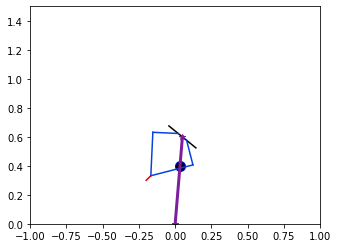

In [20]:
#animate it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes
ax1.set_aspect('equal')

# arrays to store values
N_time = []

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([x_low_lim,x_high_lim])
    ax.set_ylim([y_low_lim,y_high_lim])
    N_time.append(i)
     
    plot_body = {}
    plot_url = {}
    plot_lrl = {}
    plot_ull = {}
    plot_lll = {}
    plot_foot = {}
    abs_angles = {}
    
    # plot boom
    ax.plot(m.boom_position[i,'X'].value, m.boom_position[i,'Y'].value, marker="o", markersize=10, markeredgecolor="blue", markerfacecolor="black")

    # plot body
    plot_body.update({('x_back'):m.q[i,'x_body'].value - 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_back'):m.q[i,'y_body'].value - 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})
    plot_body.update({('x_front'):m.q[i,'x_body'].value + 0.5*m.lengths['body']*cos(m.q[i,'theta_body'].value)})
    plot_body.update({('y_front'):m.q[i,'y_body'].value + 0.5*m.lengths['body']*sin(m.q[i,'theta_body'].value)})  
    ax.plot([plot_body['x_back'],plot_body['x_front']],[plot_body['y_back'],plot_body['y_front']],color='xkcd:black')
    
    for leg in legs:
    
        if leg == 'A':
            link_colour = ['blue','red']
        else:
            link_colour = ['green','purple']
            
        #plot upper right
        abs_angles.update({('RU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_url'+leg].value})
        plot_url.update({('top','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_url.update({('top','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_url.update({('bot','X',leg): m.q[i,'x_body'].value + 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*cos(abs_angles['RU',leg])})
        plot_url.update({('bot','Y',leg): m.q[i,'y_body'].value + 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['url'+leg]*sin(abs_angles['RU',leg])})
        ax.plot([plot_url['top','X',leg],plot_url['bot','X',leg]],[plot_url['top','Y',leg],plot_url['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))
        
        #plot lower right
        abs_angles.update({('RL',leg): m.q[i,'theta_lrl'+leg].value - (np.pi-abs_angles['RU',leg])})
        plot_lrl.update({('top','X',leg): plot_url['bot','X',leg]})
        plot_lrl.update({('top','Y',leg): plot_url['bot','Y',leg]})
        plot_lrl.update({('bot','X',leg): plot_url['bot','X',leg] - m.lengths['lrl'+leg]*cos(abs_angles['RL',leg])})
        plot_lrl.update({('bot','Y',leg): plot_url['bot','Y',leg] - m.lengths['lrl'+leg]*sin(abs_angles['RL',leg])})
        ax.plot([plot_lrl['top','X',leg],plot_lrl['bot','X',leg]],[plot_lrl['top','Y',leg],plot_lrl['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot upper left
        abs_angles.update({('LU',leg): m.q[i,'theta_body'].value + m.q[i,'theta_ull'+leg].value})
        plot_ull.update({('top','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value)})
        plot_ull.update({('top','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value)})
        plot_ull.update({('bot','X',leg): m.q[i,'x_body'].value - 0.5*m.LL.value*cos(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*cos(abs_angles['LU',leg])})
        plot_ull.update({('bot','Y',leg): m.q[i,'y_body'].value - 0.5*m.LL.value*sin(m.q[i,'theta_body'].value) - m.lengths['ull'+leg]*sin(abs_angles['LU',leg])})
        ax.plot([plot_ull['top','X',leg],plot_ull['bot','X',leg]],[plot_ull['top','Y',leg],plot_ull['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot lower left
        abs_angles.update({('LL',leg):m.q[i,'theta_lll'+leg].value - (np.pi-abs_angles['LU',leg])})
        plot_lll.update({('top','X',leg): plot_ull['bot','X',leg]})
        plot_lll.update({('top','Y',leg): plot_ull['bot','Y',leg]})
        plot_lll.update({('bot','X',leg): plot_ull['bot','X',leg] - m.lengths['lll'+leg]*cos(abs_angles['LL',leg])})
        plot_lll.update({('bot','Y',leg): plot_ull['bot','Y',leg] - m.lengths['lll'+leg]*sin(abs_angles['LL',leg])})
        ax.plot([plot_lll['top','X',leg],plot_lll['bot','X',leg]],[plot_lll['top','Y',leg],plot_lll['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[0]))

        #plot foot
        mu = 150*(np.pi/180) 
        plot_foot.update({('top','X',leg): plot_lll['bot','X',leg]})
        plot_foot.update({('top','Y',leg): plot_lll['bot','Y',leg]})
        plot_foot.update({('bot','X',leg): plot_foot['top','X',leg] + m.lengths['foot'+leg]*cos(mu-abs_angles['RL',leg])})
        plot_foot.update({('bot','Y',leg): plot_foot['top','Y',leg] - m.lengths['foot'+leg]*sin(mu-abs_angles['RL',leg])})
        ax.plot([plot_foot['top','X',leg],plot_foot['bot','X',leg]],[plot_foot['top','Y',leg],plot_foot['bot','Y',leg]],color='xkcd:{0}'.format(link_colour[1]))
        
        ax.plot([0,m.q[i,'x_body'].value],[0,m.q[i,'y_body'].value],color='xkcd:purple',marker='*',linewidth='3.0') # plot the ground
    # draw boom    
    ax.plot([-10,10],[-10,-10]) # plot the ground
    
    
update = lambda i: plot_robot(i,m,ax1) # lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=True)

HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook


In [21]:
f = r"{0}.mp4".format(test) 
writervideo = ani.FFMpegWriter(fps=20) 
animate.save(f, writer=writervideo)  

len(N_time)

102

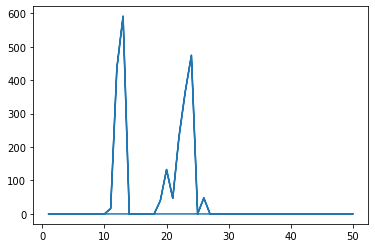

In [22]:
dd_ullA_plot = []
dd_yb_plot = []
GRF_Y_plot = []
left_knee = []
right_knee = []
left_torque = []

for n in N_time:
    for leg in legs:
        GRF_Y_plot.append(m.GRF_y[n,'A'].value)
        dd_ullA_plot.append(m.ddq[n,'theta_urlA'].value)
        dd_yb_plot.append(m.ddq[n,'y_body'].value)
        left_knee.append(2*np.pi - m.q[n,'theta_lll'+leg].value)
        left_torque.append(m.tau_torque[n,'+ve','left','A'].value-m.tau_torque[n,'-ve','left','A'].value)
    
# plt.plot(N_time[2:],dd_ullA_plot[2:])
plt.plot(N_time[:],GRF_Y_plot[:])
# plt.figure()
# plt.plot(N_time,right_tau)

In [23]:
print(results.solver.termination_condition) # check if optimal

maxIterations


<a href='#initial_conditions'>Link to initial conditions'</a>

<a href='#time_step'>Link to time step'</a>